# Predicting Suicidality and Suicidal Thoughts on Reddit

## Setup

In [1]:
# Import libraries and helper functions
import warnings
warnings.filterwarnings('ignore')
from utils import *

In [2]:
# Read in data
import pandas as pd
reddit_data = pd.read_csv("~/Desktop/Work/Github/_data/Suicide_Detection.csv", 
                        index_col = 0).reset_index(drop=True)
reddit_data.sample(5, random_state= 1)  # peak at a random sample of 5 rows

,text,class
79689,I want to go to sleep and never wake upMy reas...,suicide
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide
226306,the sun is setting and it's raining i'm curren...,non-suicide
101296,Hi. Im scared. Plz talk to me.Private message,suicide
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide


In [3]:
reddit_data.info()      # data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


The dataset has two columns, both in correct data types and there are no missing values.

## Text Analysis 

### Distribution of target variable classes

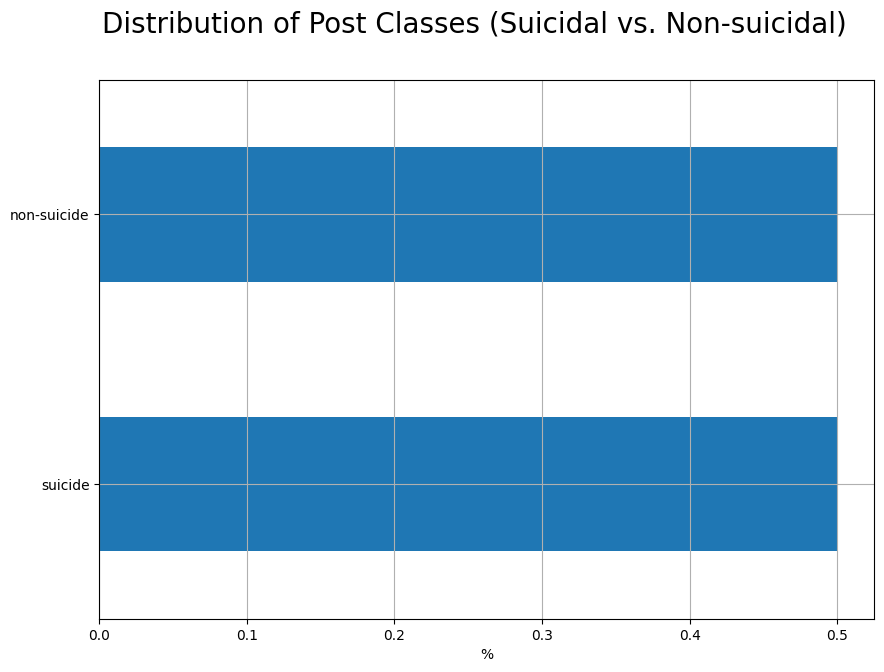

In [4]:
# Evaluate distribution of post classes (target variable)
plot_distributions(data=reddit_data, x="class", figsize=(10,7), title= "Distribution of Post Classes (Suicidal vs. Non-suicidal)", 
                    xlabel="%", normalize=True)

The target variable is perfectly balanced, meaning 50% are suicidal posts while the other half is not. 

In [5]:
sample_data = reddit_data.sample(frac=0.01, random_state=1)

### NER

Additionally, Name Entity Recognition will be done below to extract more features and understand which ones are more common in reddit posts

In [6]:
tags_list = ["ORG","PERSON","NORP","GPE","LOC","FAC","EVENT","PRODUCT","WORK_OF_ART"]
model = spacy.load("en_core_web_lg")
sample_data = add_ner_spacy(dtf = sample_data, column = "text", lst_tag_filter = tags_list, create_features=True)

--- tagging ---


100%|██████████| 2321/2321 [01:10<00:00, 33.02it/s]


--- counting tags ---


100%|██████████| 2321/2321 [00:00<00:00, 520782.09it/s]


--- creating features ---


100%|██████████| 2321/2321 [00:00<00:00, 611109.83it/s]


In [7]:
# look at a few rows 
sample_data.head()

,text,class,text_tagged,tags,tags_ORG,tags_WORK_OF_ART,tags_LOC,tags_PERSON,tags_FAC,tags_EVENT,tags_GPE,tags_NORP,tags_PRODUCT
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...",[{('https://www.webtoons.com/en/challenge/dood...,1,0,0,0,0,0,0,0,0
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",1,0,0,0,0,0,0,0,0
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Political Science', 'ORG'): 1}, {('Reddit'...",2,0,0,0,0,0,0,0,0


Class: suicide


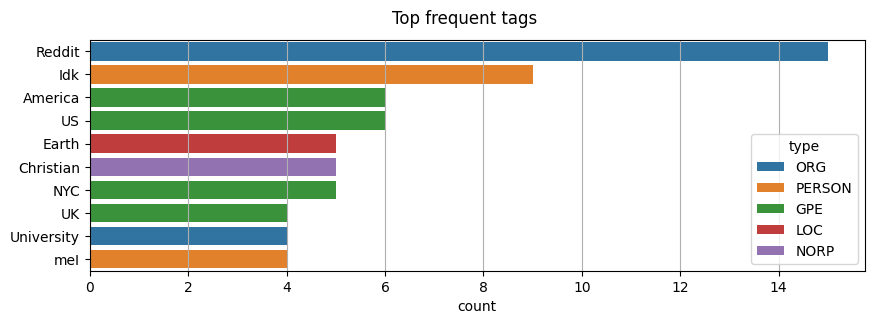

Class: non-suicide


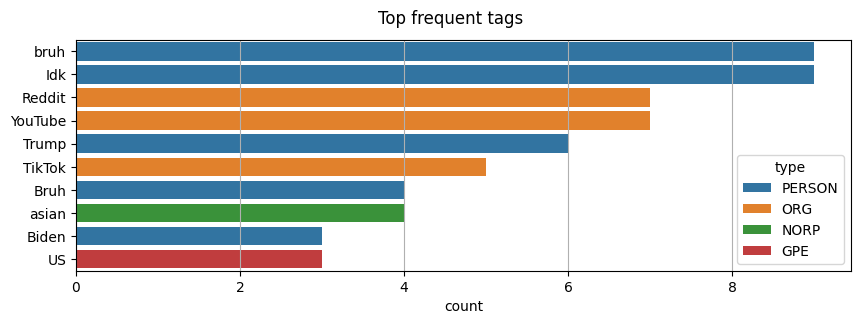

In [8]:
# plot distribution of tags by class
for label in sample_data["class"].unique():
    print(f"Class: {label}")
    common_tags = plot_tags(tags=sample_data[sample_data["class"]== label]["tags"], top=10, figsize=(10,3))

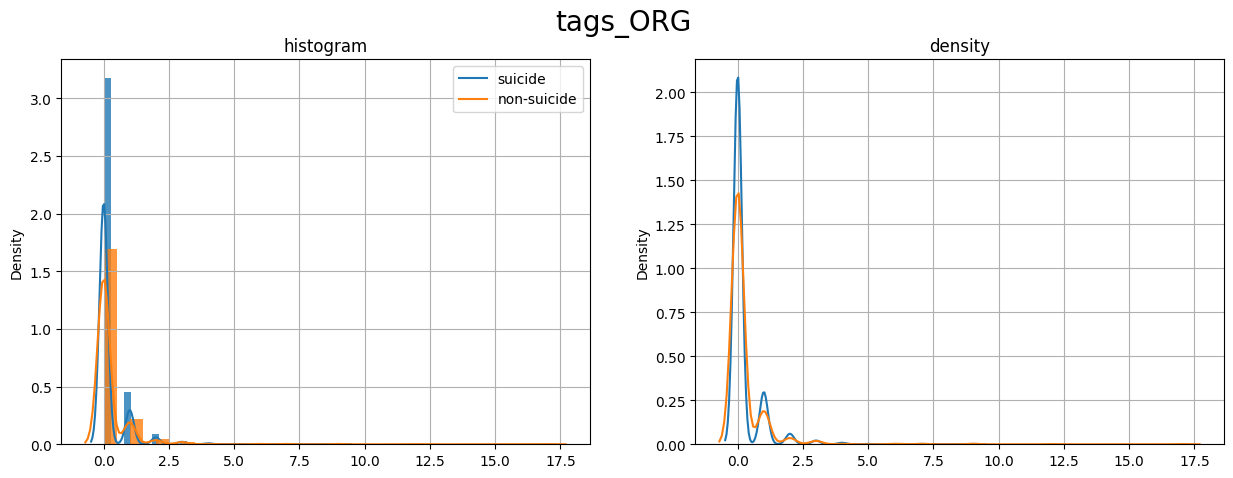

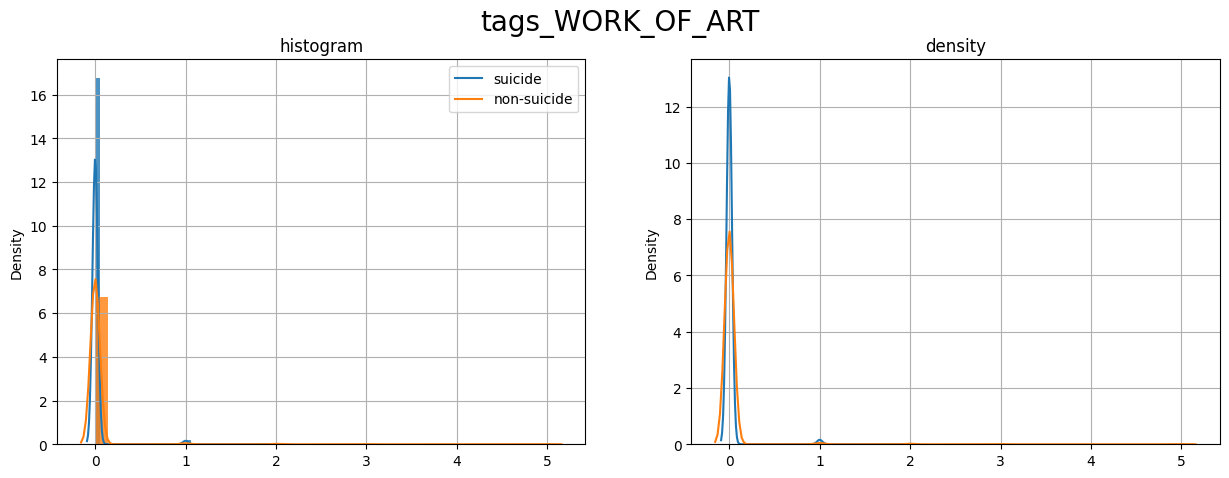

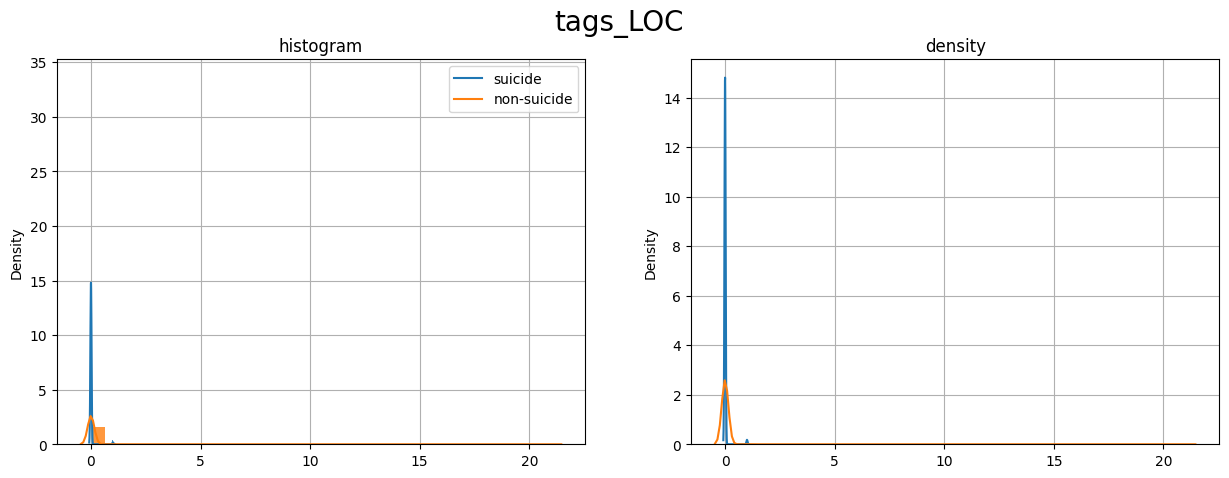

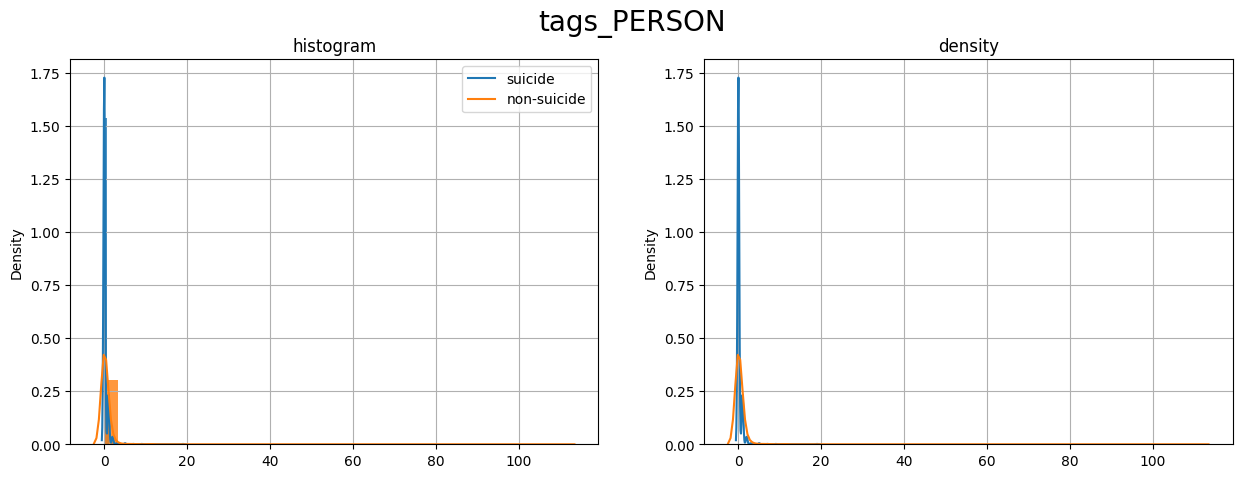

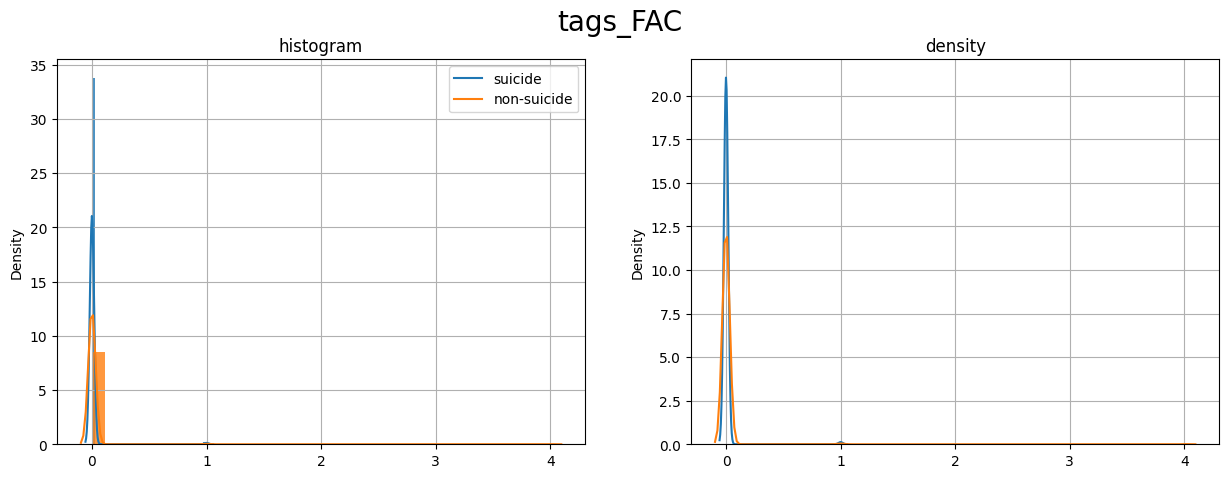

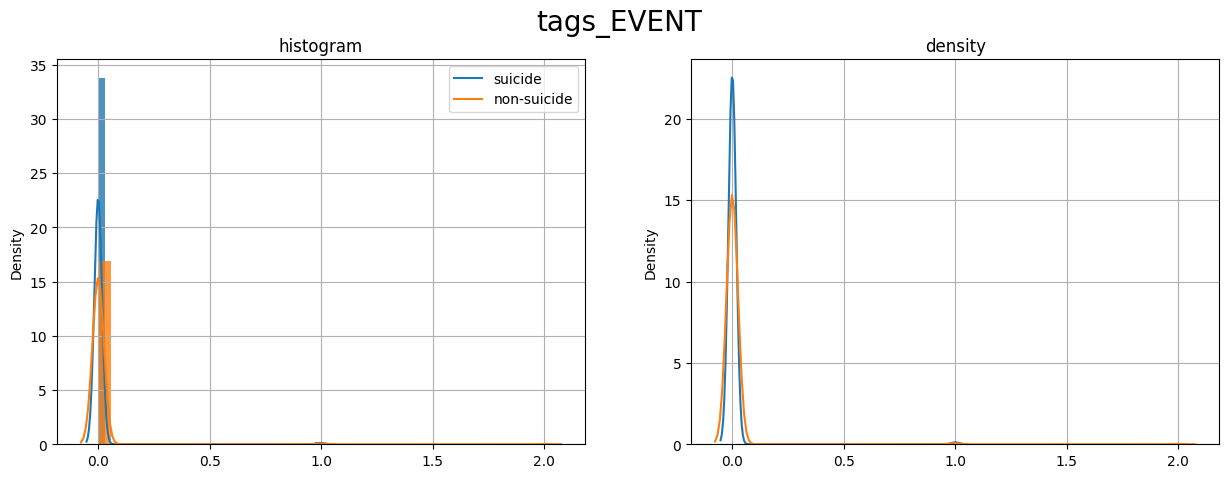

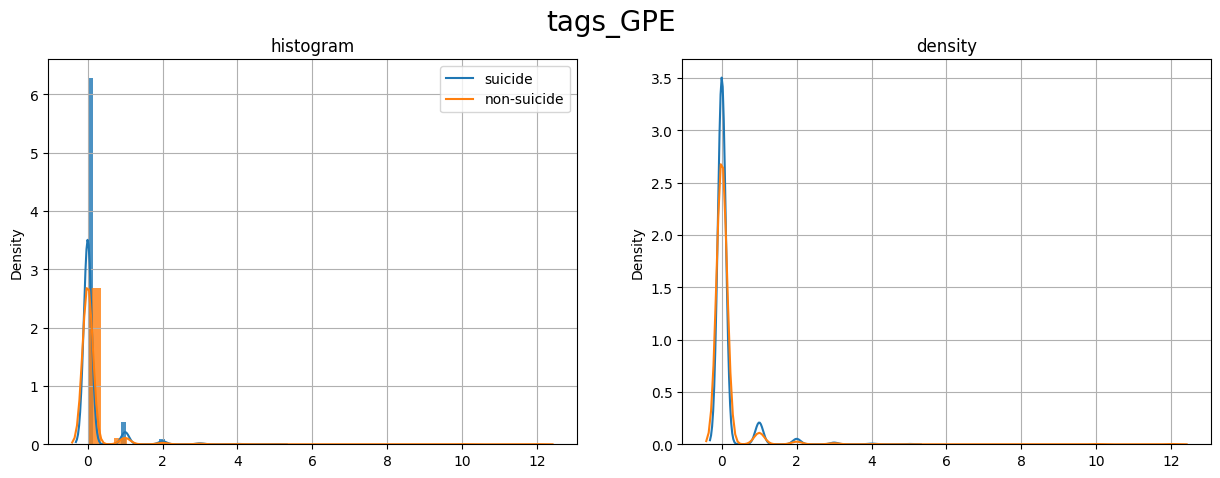

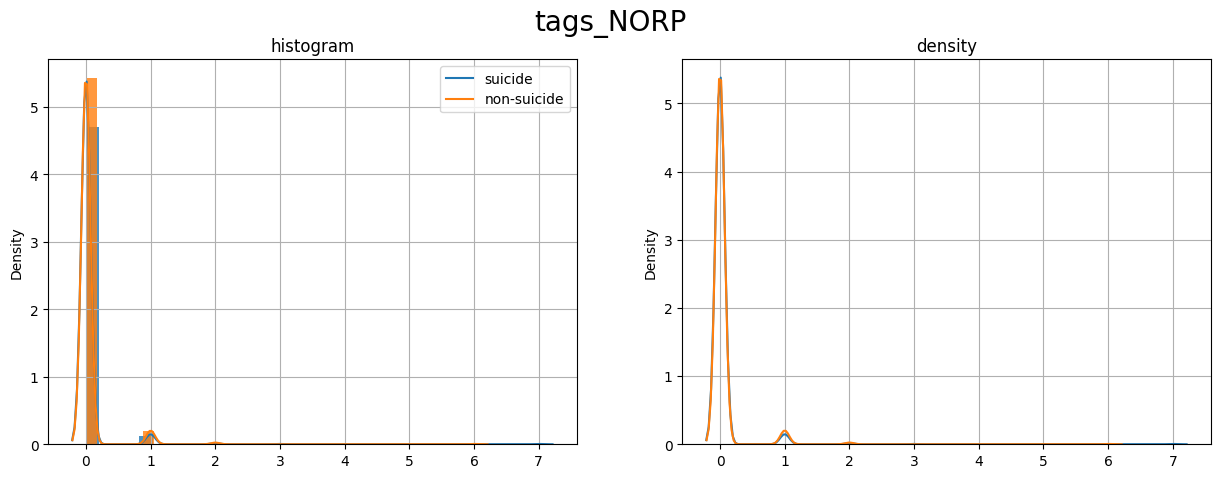

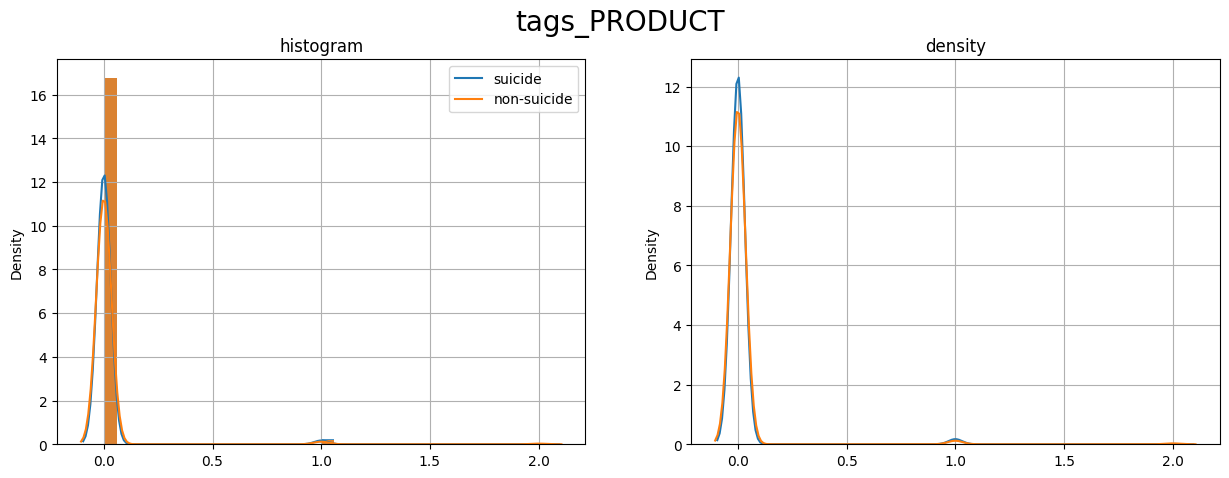

In [9]:
for x in sample_data.filter(like="tags_", axis=1).columns:
    plot_distributions(sample_data, x= x, y="class", bins=None, figsize=(15,5))

### More text characteristics
Features to be extracted from each post (processed text): 
- Number of words
- Number of characters
- Number of sentences
- Average word length
- Average sentence length

In [10]:
sample_data = extract_lengths(data=sample_data, col="text")

100%|██████████| 2321/2321 [00:00<00:00, 11957.57it/s]


Characteristics of text:

                      min        mean      max
char_count      12.000000  572.966394  29736.0
word_count       1.000000  160.161568   7538.0
sentence_count   1.000000    8.539423    362.0
avg_word_len     1.020408    3.696616     56.0
avg_sent_len     1.000000   24.199056    864.0


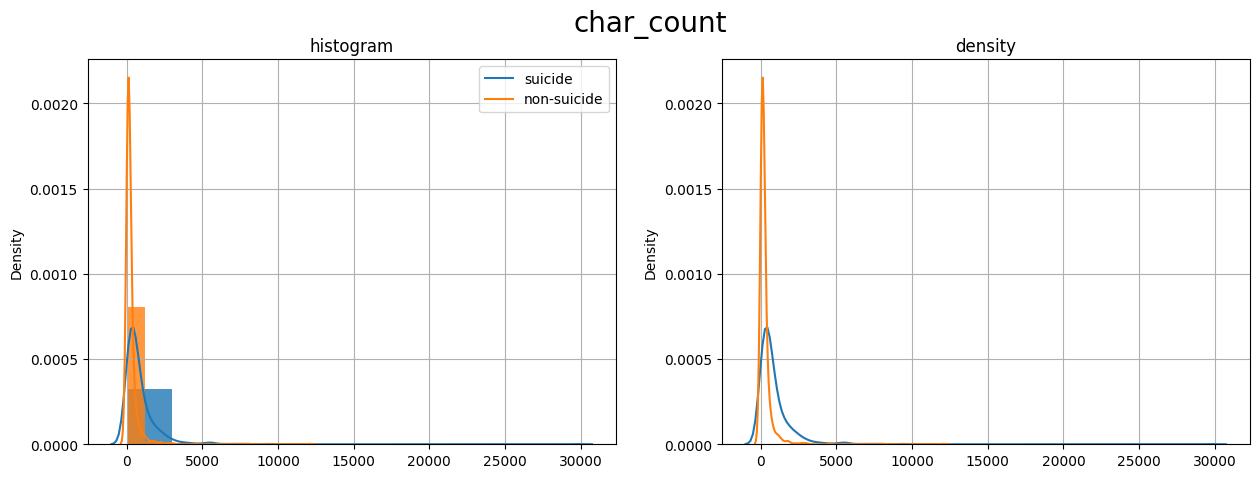

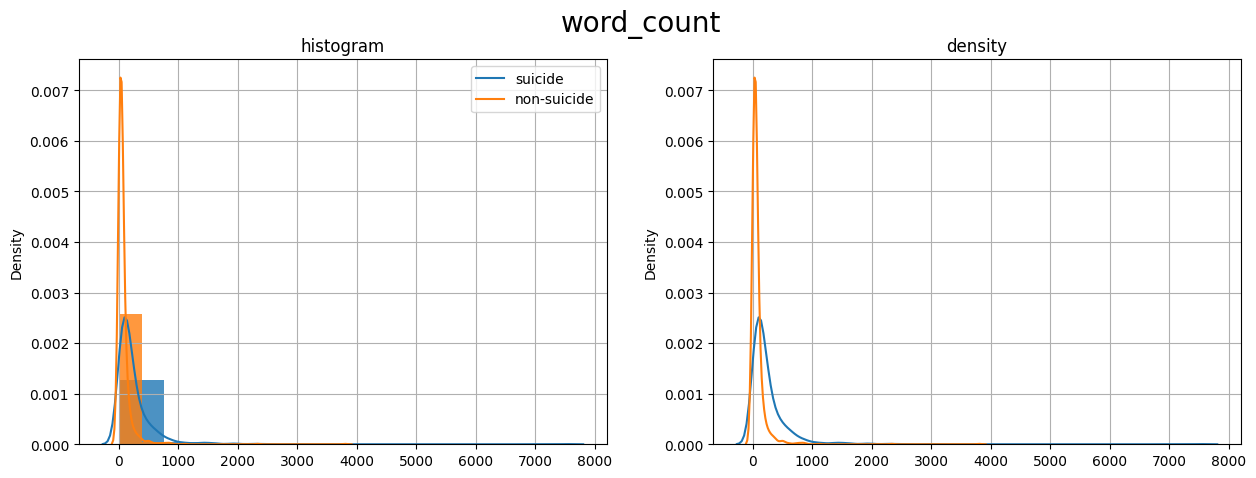

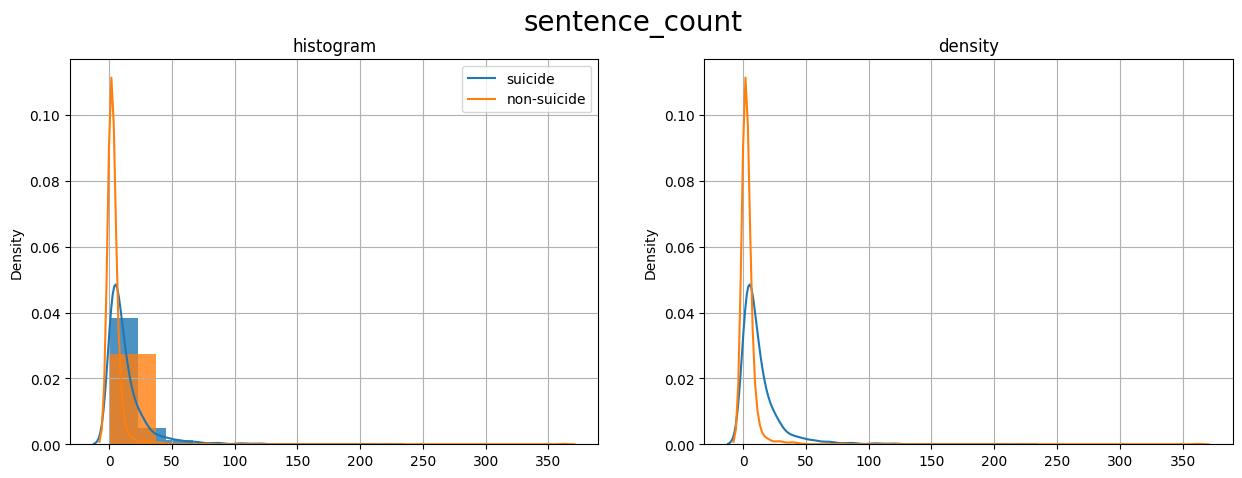

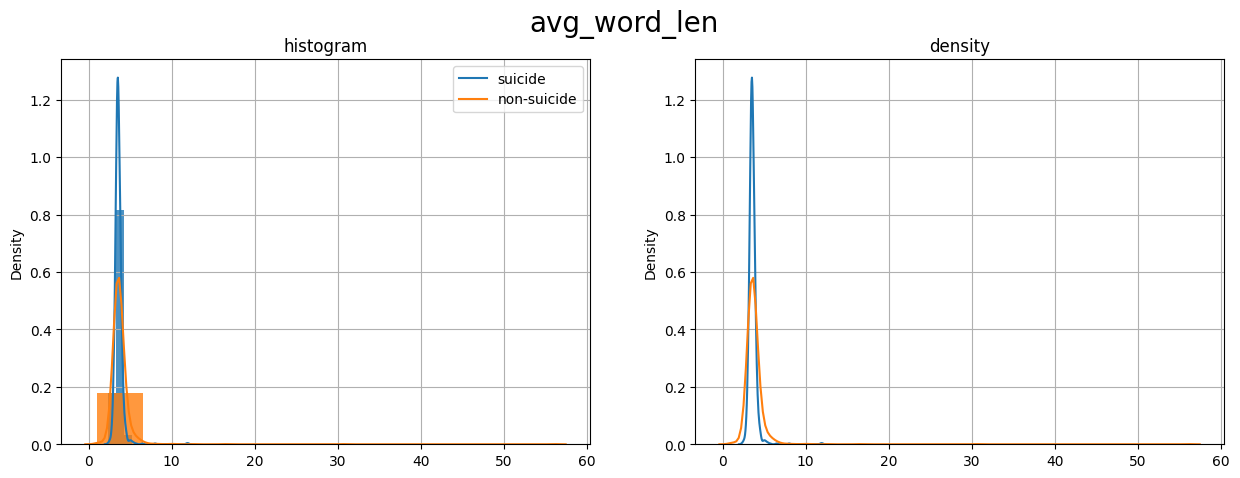

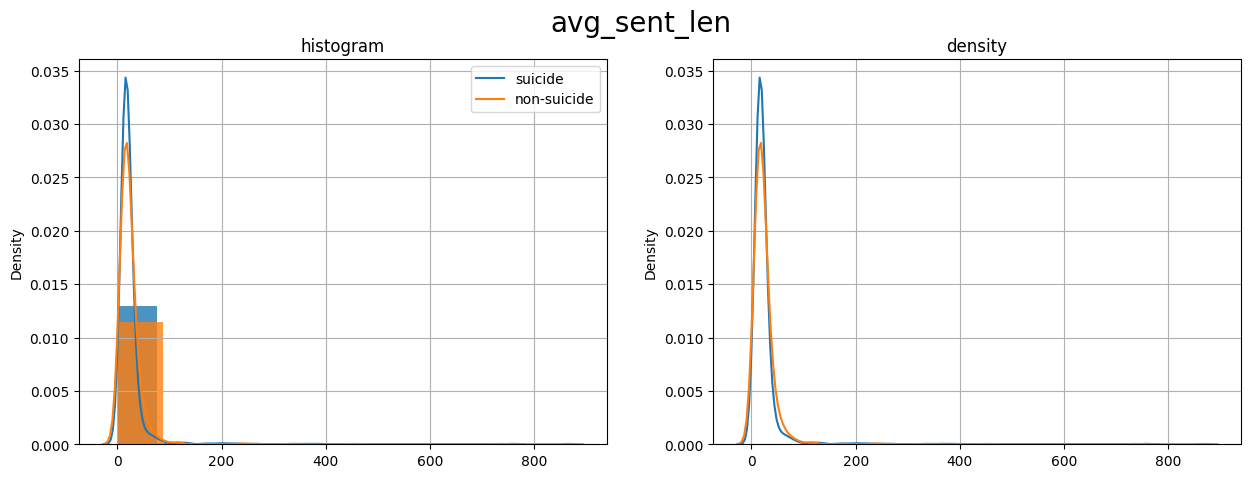

In [11]:
for col in ["char_count","word_count","sentence_count","avg_word_len","avg_sent_len"]:
    plot_distributions(sample_data, x=col, y="class", bins=10, figsize=(15,5))

### Text cleaning

In [12]:
stopwords = stopwords_list()        # use default NLTK english stopwords
sample_data = append_clean_text(sample_data, column="text")

100%|██████████| 2321/2321 [00:00<00:00, 1462367.37it/s]


In [13]:
sample_data.head()

,text,class,text_tagged,tags,tags_ORG,tags_WORK_OF_ART,tags_LOC,tags_PERSON,tags_FAC,tags_EVENT,tags_GPE,tags_NORP,tags_PRODUCT,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmi reason might mak...
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...",[{('https://www.webtoons.com/en/challenge/dood...,1,0,0,0,0,0,0,0,0,67,309,1,4.611940,67.000000,yo ive done someth ive start webtoon httpswwww...
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",1,0,0,0,0,0,0,0,0,29,96,2,3.310345,14.500000,sun set rain im current listen sad pov song yo...
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi im scare plz talk mepriv messag
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Political Science', 'ORG'): 1}, {('Reddit'...",2,0,0,0,0,0,0,0,0,283,1125,8,3.975265,35.375000,feel hopeworthlessnessthi stupid reason feel w...


### Sentiment Analysis

In [14]:
sample_data = add_sentiment(sample_data, "text_clean", algo="textblob", sentiment_range=(-1,1)) # sentiment for a range of -1 to 1
sample_data.head()

100%|██████████| 2321/2321 [00:00<00:00, 4952.08it/s]

            count      mean       std  min       25%  50%       75%  max
sentiment  2321.0  0.003072  0.247364 -1.0 -0.109438  0.0  0.116667  1.0


,text,class,text_tagged,tags,tags_ORG,tags_WORK_OF_ART,tags_LOC,tags_PERSON,tags_FAC,tags_EVENT,tags_GPE,tags_NORP,tags_PRODUCT,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean,sentiment
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmi reason might mak...,0.160204
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...",[{('https://www.webtoons.com/en/challenge/dood...,1,0,0,0,0,0,0,0,0,67,309,1,4.611940,67.000000,yo ive done someth ive start webtoon httpswwww...,0.500000
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",1,0,0,0,0,0,0,0,0,29,96,2,3.310345,14.500000,sun set rain im current listen sad pov song yo...,-0.250000
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi im scare plz talk mepriv messag,0.000000
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Political Science', 'ORG'): 1}, {('Reddit'...",2,0,0,0,0,0,0,0,0,283,1125,8,3.975265,35.375000,feel hopeworthlessnessthi stupid reason feel w...,-0.178125


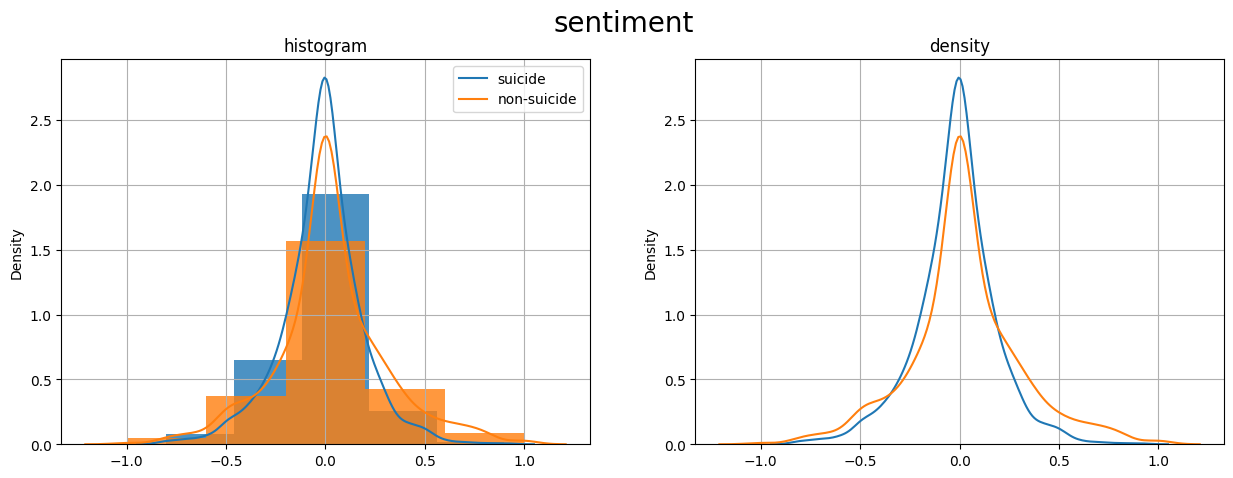

In [15]:
plot_distributions(sample_data, x="sentiment", y="class", bins=5, figsize=(15,5))


# suicide:


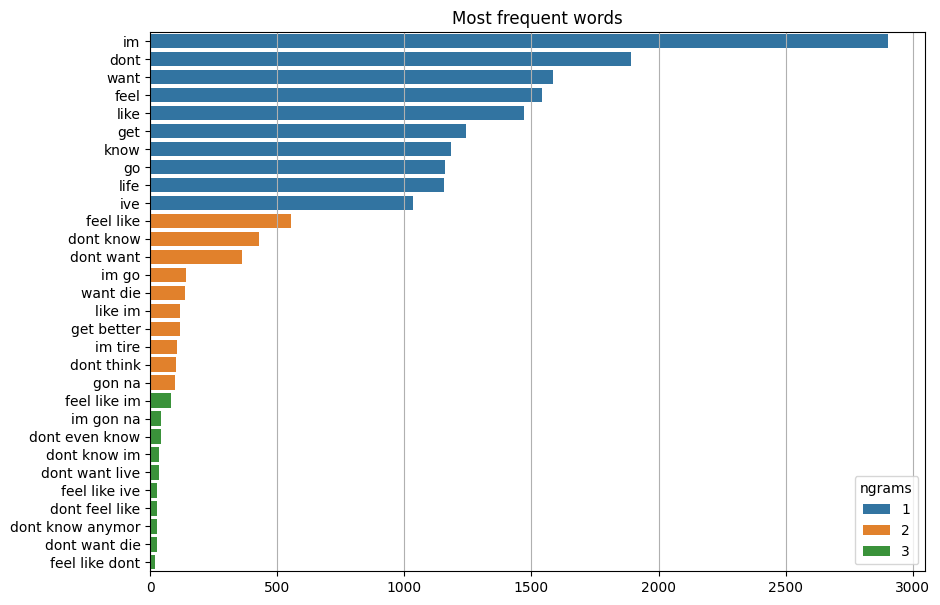

# non-suicide:


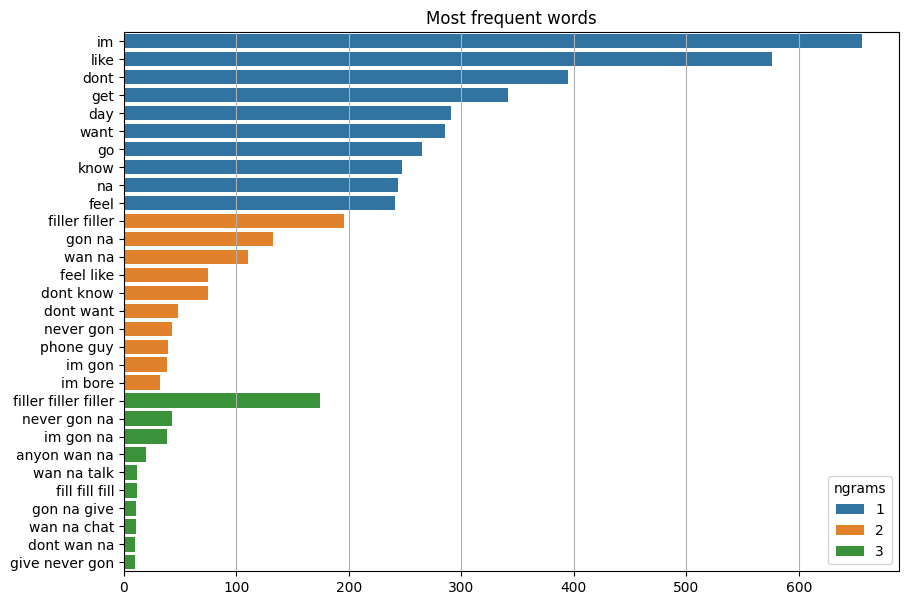

In [16]:
dtf_freq = pd.DataFrame()
for y in sample_data["class"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=sample_data[sample_data["class"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["class"] = y
    dtf_freq = dtf_freq.append(dtf_y)


## TODO: There are still many stop words and contraction wasn't correctly done. Please go back to this! ## Remove numbers, links


### Word Frequency and Word Could

# suicide:


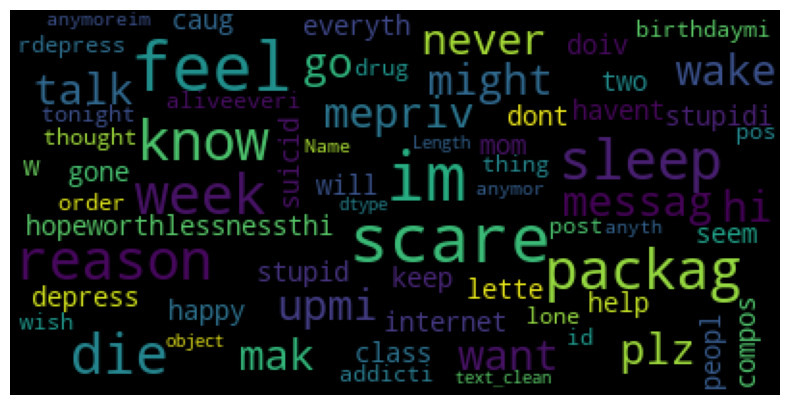

# non-suicide:


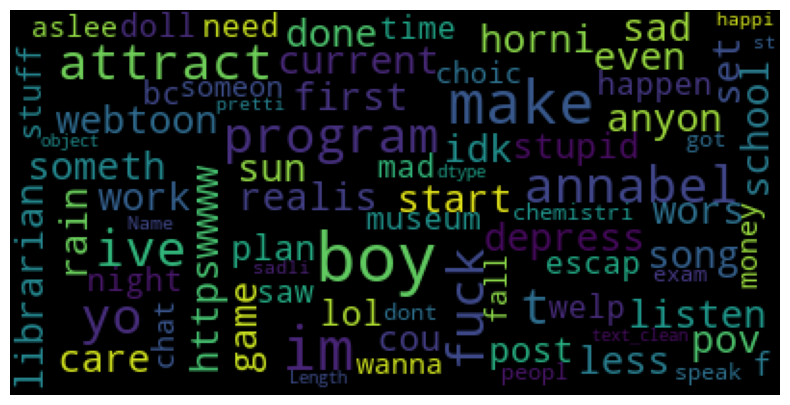

In [17]:
for y in sample_data["class"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=sample_data[sample_data["class"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

COMMENT: In the suicidal word cloud we have "text_clean" which is my column name. Investigate his. Otherwise, the wordclouds between the two groups are different; the suicidal group word cloud shows more of feeling words (e.g. depression, scared, suicide, feel, thought, sleep), while the non-suicidal group word cloud is mostly non-negative feeling words. 

also remove https links

### ALL FEATURES

In [18]:
sample_data.head()

,text,class,text_tagged,tags,tags_ORG,tags_WORK_OF_ART,tags_LOC,tags_PERSON,tags_FAC,tags_EVENT,tags_GPE,tags_NORP,tags_PRODUCT,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean,sentiment
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmi reason might mak...,0.160204
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...",[{('https://www.webtoons.com/en/challenge/dood...,1,0,0,0,0,0,0,0,0,67,309,1,4.611940,67.000000,yo ive done someth ive start webtoon httpswwww...,0.500000
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",1,0,0,0,0,0,0,0,0,29,96,2,3.310345,14.500000,sun set rain im current listen sad pov song yo...,-0.250000
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi im scare plz talk mepriv messag,0.000000
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Political Science', 'ORG'): 1}, {('Reddit'...",2,0,0,0,0,0,0,0,0,283,1125,8,3.975265,35.375000,feel hopeworthlessnessthi stupid reason feel w...,-0.178125


## Preprocessing

### Encoding target variable

In [19]:
#mapping 1 to suicidal and 0 to non-suicidal posts
sample_data['class'] = sample_data['class'].map({'suicide': 1, 'non-suicide':0}) 

### Data partitioning

In [22]:
# define data and target for our data
X = sample_data["text_clean"]
y = sample_data["class"]

# split data in train, split sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 12)

Creating sparse matrices...
Shape of training matrix: (1624, 8353)
Shape of test matrix: (697, 8353)


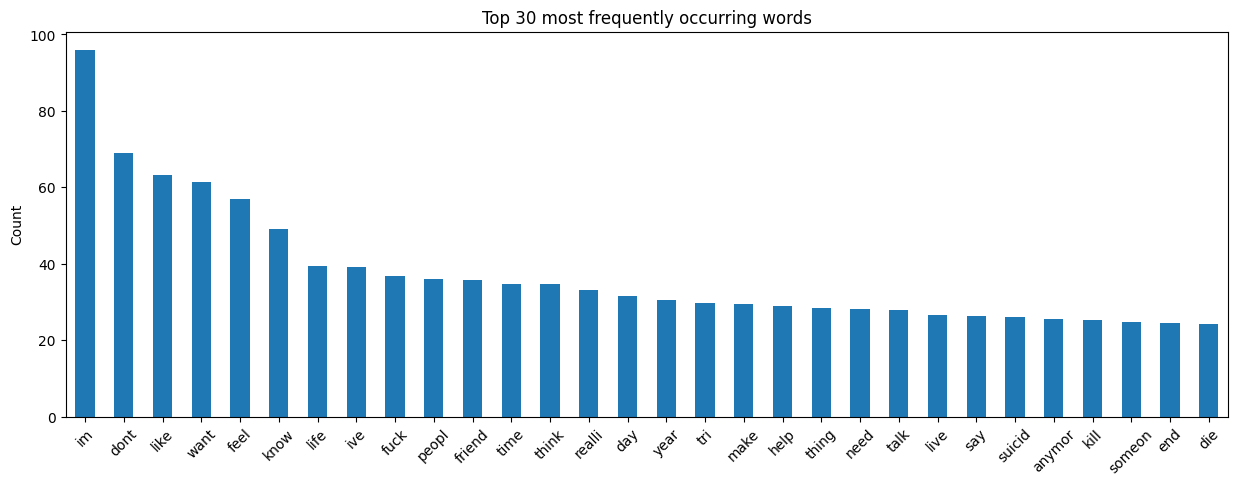

In [28]:
## bag of words and plot most frequently occuring words
bow(X_train=X_train, X_test=X_test, top=30)

In [38]:
def bow(X_train, X_test, vectorizer = None, top = 20): 
    # vectorize 
    print("Creating sparse matrices...")
    stemmer = nltk.stem.porter.PorterStemmer() 
    vectorizer = feature_extraction.text.TfidfVectorizer(stop_words= 'english', ngram_range= (1,3), 
                                                        tokenizer= lambda x: [stemmer.stem(i) for i in x.split(" ")]) if vectorizer is None else vectorizer
    X_train_transformed = vectorizer.fit_transform(X_train)
    print(f"Shape of training matrix: {X_train_transformed.shape}")
    X_test_transformed = vectorizer.transform(X_test)
    print(f"Shape of test matrix: {X_test_transformed.shape}")

    # visualize top words in the train set
    word_counts = pd.DataFrame({"counts": X_train_transformed.toarray().sum(axis=0)}, 
                                index=vectorizer.get_feature_names_out()).sort_values("counts", 
                                ascending=False)

    word_counts.head(top).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title(f"Top {top} most frequently occurring words")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

    return {"X_train_transformed":X_train_transformed, "X_test_transformed": X_test_transformed}

Creating sparse matrices...
Shape of training matrix: (1624, 1000)
Shape of test matrix: (697, 1000)


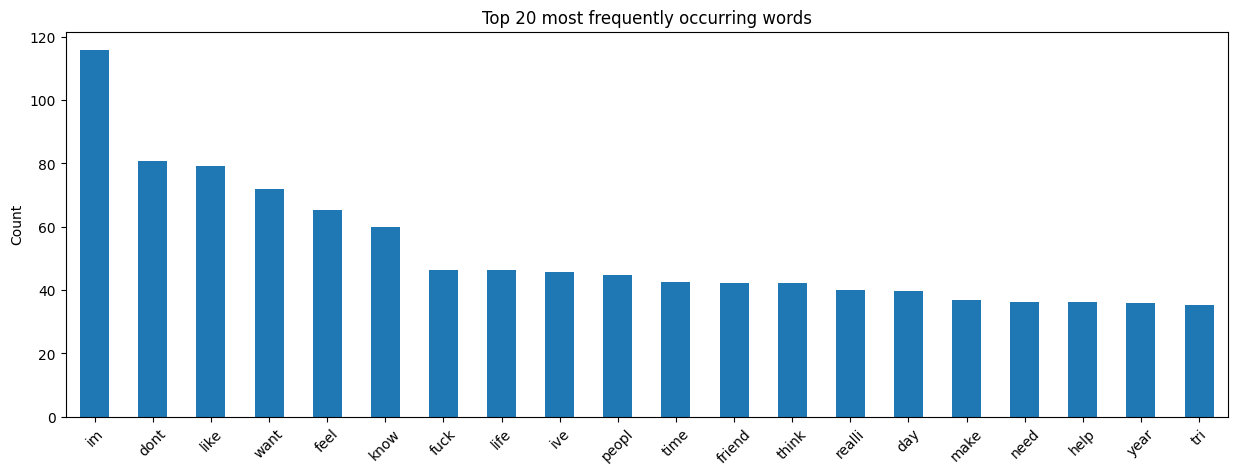

In [49]:
stemmer = nltk.stem.porter.PorterStemmer()
vectorizer = feature_extraction.text.TfidfVectorizer(min_df = 5, max_features = 1000, 
                                                    stop_words= 'english', ngram_range= (1,3), 
                                                    tokenizer= lambda x: [stemmer.stem(i) for i in x.split(" ")])
dic_bow = bow(X_train = X_train, X_test = X_test, vectorizer=vectorizer, top = 20)
X_train_transformed, X_test_transformed = dic_bow["X_train_transformed"], dic_bow["X_test_transformed"]

## Classifiers

### Logistic Regression

Read more about confusion matrix after cross validation at [cross validation](https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874)

In [66]:
# Logistic Regression
logreg = linear_model.LogisticRegression()
kfold = model_selection.KFold(n_splits=10, random_state=12, shuffle=True)
actual_classes, predicted_classes, _ = cross_validation_(model = logreg, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Logistic Regression: 0.8756191774596683


In [ ]:
# KNN
knn_mod = neighbors.KNeighborsClassifier() 
actual_classes, predicted_classes, _ = cross_validation_(model = knn_mod, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Logistic Regression: 0.8756191774596683


In [ ]:
# Decision Tree
tree_mod = tree.DecisionTreeClassifier()
actual_classes, predicted_classes, _ = cross_validation_(model = tree_mod, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Logistic Regression: 0.8756191774596683


In [ ]:
# XGBOOST
xgb_clf = xgb.XGBClassifier() 
actual_classes, predicted_classes, _ = cross_validation_(model = xgb_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Logistic Regression: 0.8756191774596683


In [ ]:
# Random Forest
rf_clf = ensemble.RandomForestClassifier()
actual_classes, predicted_classes, _ = cross_validation_(model = rf_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Logistic Regression: 0.8756191774596683


In [ ]:
# SVM
svm_clf = svm.SVC() 
actual_classes, predicted_classes, _ = cross_validation_(model = rf_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Logistic Regression: 0.8756191774596683


## TODO: 
[EVAL](https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/)

[EVAL2](https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0)

In [103]:
models = []
models.append(('LR', linear_model.LogisticRegression()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('CART', tree.DecisionTreeClassifier()))
models.append(('XGBOOST', xgb.XGBClassifier()))
models.append(('RF', ensemble.RandomForestClassifier()))
models.append(('SVM', svm.SVC()))

# evaluate each model in turn
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
# result_df = pd.DataFrame()
dfs = []
for name, model in models:
	cv_results = model_selection.cross_validate(model, X_train_transformed, y_train, cv=kfold, scoring=scoring)
	# results.append(cv_results)
	# names.append(name)

	# this_df = pd.DataFrame(cv_results)
	# this_df['model'] = name
	# dfs.append(this_df)

	# result_df.append({"name": name, "results": cv_results}, ignore_index=True)
	# msg = f"{name}: {round(cv_results.mean(), 2)} \u00B1 {round(cv_results.std(), 2)}"
	# print(msg)
# boxplot algorithm comparison
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# sns.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

In [150]:
models = []
models.append(('LR', linear_model.LogisticRegression()))
models.append(('KNN', neighbors.KNeighborsClassifier()))
# models.append(('CART', tree.DecisionTreeClassifier()))
# models.append(('XGBOOST', xgb.XGBClassifier()))
# models.append(('RF', ensemble.RandomForestClassifier()))
# models.append(('SVM', svm.SVC()))

# evaluate each model in turn
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
# result_df = pd.DataFrame()
result_df = pd.DataFrame(columns= [
					'fit_time', 'score_time', 'test_accuracy', 'test_precision_weighted',
					'test_recall_weighted', 'test_f1_weighted', 'model'
					]
	   )
for name, model in models:
	cv_results = model_selection.cross_validate(model, X_train_transformed, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)

	temp_df = pd.DataFrame(cv_results)
	temp_df['model'] = name
	result_df.append(temp_df, ignore_index = True)

## Modeling

### Baseline Models (Bag of Words + ML models)

Before any modeling the following should be done: 
- Vectorize posts using TFIDF
- Feature Selection/Reduce Dimensions (PCA?)
- Train models: 
    - Logistic Regression
    - KNN 
    - Decision Tree
    - XGBoost 
    - Random Forest 
    - SVM 
- Choose top 3 models based on accuracy
- Parameter optimization for top 3 models
- Precision/Recall for evaluation
- Train a NN (Transfer learning?)
- Choose model based on accuracy, explainability, and computation time

Maybe make a flowchart for this process for better understanding?

### Baseline Models (Bag of words)

In [ ]:
## use TFIDf for vectorization
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False)


## Data Pre-processing and Cleaning

### 1. Dealing with contractions

### 2. Stemming, tokenization, and stop words

In [18]:
## Stemming
porter = PorterStemmer()            # instatiate porter stemmer

def stem_porter(post: str) -> list:
    """
    Stem words after tokenization.

    Input text is first coverted to tokens then a Porter Stemmer 
    is applied to each token.

    Parameters
    ---------
    post: str
        sentence to be tokinized then stemmed.

    Returns
    ---------
    stemmed_post: list of strings
        stemmed sentence after tokenization.
    """
    stemmed_post = [porter.stem(word) for word in word_tokenize(post)]
    return stemmed_post

## Stop words
en_stop_words = stopwords.words('english')      # load all NLTK stop words

def tokenizer(post: str) -> list:
    """ 
    Preprocess text before vectorization.

    Any form of punctuation is first removed from the input text, while emoticons
    in the text are preserved. For input text is then processed using `stem_porter`
    function and finally outputs the text with no stop words. 

    Parameters
    ----------
    post: str
        post text to be processed
    
    Returns
    ---------
    tokenized: list of strings
        processed text with punctuations or stop words, with emoticons preserved

    See Also
    ---------
    stem_porter: Stem words after tokenization.

    """
    sentence = post.translate(str.maketrans('', '', string.punctuation)).lower()
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', sentence)
    sentence += ' '.join(emoticons).replace('-', '') 
    tokenized = [w for w in stem_porter(sentence) if w not in en_stop_words]

    return tokenized

<function matplotlib.pyplot.show(close=None, block=None)>

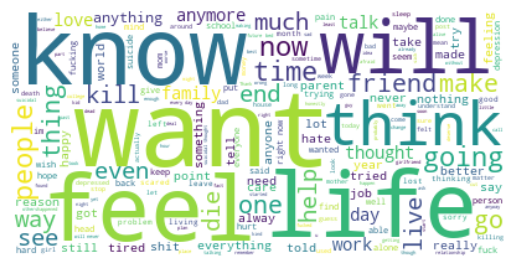

In [19]:
# creating a word cloud
test = reddit_data.copy()

suicidal_posts = test[test.suicidal == 1]
non_suicidal_posts = test[test.suicidal == 0]
suic_word_cloud = " ".join(post for post in suicidal_posts.post)
non_suic_word_cloud = " ".join(post for post in non_suicidal_posts.post)
stop_words = set(STOPWORDS)

word_cloud = WordCloud(stopwords = stop_words, background_color= 'white')

# plt.subplots(nrows = 1, ncols = 2)
# plt.subplot(1, 2, 1)
cloud_gen_suic = word_cloud.generate(suic_word_cloud)
plt.imshow(cloud_gen_suic, interpolation="bilinear")
plt.axis('off')
plt.show

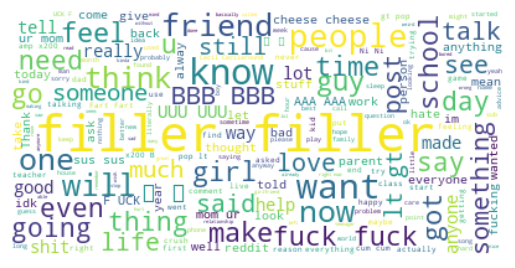

In [20]:
# plt.subplot(1, 2, 2)
cloud_gen_nonsuic = word_cloud.generate(non_suic_word_cloud)
plt.imshow(cloud_gen_nonsuic, interpolation="bilinear")
plt.axis('off')
plt.show()

## Modeling

## Use basic features with CountVectorizer for base accuracies

In [ ]:
# create copy of dataset
reddit_df = reddit_data.copy()

# define data and target for our data
X = reddit_df['post']
y = reddit_df['suicidal']

# split data in train, split sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

In [13]:
bag_of_words = CountVectorizer(tokenizer = tokenizer)
X_train_transformed = bag_of_words.fit_transform(X_train)
X_test_transformed = bag_of_words.transform(X_test)

In [14]:
# Logistic Regression
logreg = LogisticRegression()
logit_accuracy = cross_val_score(logreg, X_train_transformed, y_train, cv = 10, scoring='accuracy')
print(f"Logistic Regression: {logit_accuracy.mean()}")

# KNN
knn_mod = KNeighborsClassifier()
knn_accuracy = cross_val_score(knn_mod, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"KNN accuracy: {knn_accuracy.mean()}")

# Decision Tree
tree_mod = DecisionTreeClassifier()
tree_accuracy = cross_val_score(tree_mod, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"Decision Tree accuracy: {tree_accuracy.mean()}")

# XGBOOST
xgb_clf = XGBClassifier()
xgb_accuracy = cross_val_score(xgb_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"XGBoost accuracy: {xgb_accuracy.mean()}")

# Random Forest
rf_clf = RandomForestClassifier()
rf_accuracy = cross_val_score(rf_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"Random Forest accuracy: {rf_accuracy.mean()}")

# SVM
svm_clf = SVC()
svm_accuracy = cross_val_score(svm_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"SVM accuracy: {svm_accuracy.mean()}")


Logistic Regression: 0.9245988240891704
KNN accuracy: 0.7782900906412475
Decision Tree accuracy: 0.8483235323081824
XGBoost accuracy: 0.9135678194451596
Random Forest accuracy: 0.8971813374749498
SVM accuracy: 0.9021120558425595


In [21]:
## Use a small sample of the data to train the model
# create copy of dataset
reddit_df = reddit_data.copy()
reddit_df_sample = reddit_df.sample(frac = 0.1, random_state = 12)


# define data and target for our data
X = reddit_df_sample['post']
y = reddit_df_sample['suicidal']

# split data in train, split sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

In [25]:
## Vectorize the data
bag_of_words = CountVectorizer(tokenizer = tokenizer)
X_train_transformed = bag_of_words.fit_transform(X_train)
X_test_transformed = bag_of_words.transform(X_test)

In [23]:
# Logistic Regression
logreg = LogisticRegression()
logit_accuracy = cross_val_score(logreg, X_train_transformed, y_train, cv = 10, scoring='accuracy')
print(f"Logistic Regression: {logit_accuracy.mean()}")

# KNN
knn_mod = KNeighborsClassifier()
knn_accuracy = cross_val_score(knn_mod, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"KNN accuracy: {knn_accuracy.mean()}")

# Decision Tree
tree_mod = DecisionTreeClassifier()
tree_accuracy = cross_val_score(tree_mod, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"Decision Tree accuracy: {tree_accuracy.mean()}")

# XGBOOST
xgb_clf = XGBClassifier()
xgb_accuracy = cross_val_score(xgb_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"XGBoost accuracy: {xgb_accuracy.mean()}")

# Random Forest
rf_clf = RandomForestClassifier()
rf_accuracy = cross_val_score(rf_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"Random Forest accuracy: {rf_accuracy.mean()}")

# SVM
svm_clf = SVC()
svm_accuracy = cross_val_score(svm_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"SVM accuracy: {svm_accuracy.mean()}")


Logistic Regression: 0.9088890109890109
KNN accuracy: 0.721372679045093
Decision Tree accuracy: 0.8402488063660478
XGBoost accuracy: 0.9053808639636225
Random Forest accuracy: 0.878785903751421
SVM accuracy: 0.8968234937476316


In [15]:
## hyperparameter optimization using solvers, penalty, and c
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] 
penalty = ['l1','l2']                              
c_values = [100, 10, 1.0, 0.1, 0.01]
# max_iter = [10, 100, 1000]

from sklearn.model_selection import GridSearchCV
grid = dict(solver = solvers, penalty = penalty, C = c_values) # initialize grid search
clf = GridSearchCV(logreg, param_grid = grid, cv = 10, n_jobs = -1, scoring='accuracy')
best_clf = clf.fit(X_train_transformed, y_train)

print(f"Best: {best_clf.best_score_} using {best_clf.best_params_}")

In [ ]:
# Test accuracy
best_clf.score(X_test_tranformed, y_test)

In [40]:
label = {0:'non-suicidal', 1:'suicidal'}

example = ["I hate myself. I am tired of life and I will kill myself"]
X = bag_of_words.transform(example)

print(f'Prediction: %s\nProbability: %.2f%%'
      %(label[logreg.predict(X)[0]],np.max(logreg.predict_proba(X))*100))

Prediction: suicidal
Probability: 87.21%


## KNN

Train set 0.8577663418507735
Test set 0.779799778808727


In [43]:
### KNN parameter optimization
from sklearn.model_selection import GridSearchCV

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p = [1,2]

hyperparams = dict(leaf_size = leaf_size, n_neighbors = n_neighbors, p = p)
knn_tuned = KNeighborsClassifier()
clf = GridSearchCV(knn_tuned, hyperparams, cv = 10, n_jobs=-1)
best_mod = clf.fit(X_train_transformed, y_train)
print(f"Best accuracy: {best_mod.best_score_} using {best_mod.best_params_}")

KeyboardInterrupt: 

## Decision Trees

Train accuracy: 0.9999384429766515
Test accuracy: 0.8501644571477817


In [45]:
## Ensemble Modeling
### Random forest
from sklearn.ensemble import RandomForestClassifier
rd_forest = RandomForestClassifier()
rd_forest.fit(X_train_transformed, y_train)
train_rd_score = rd_forest.score(X_train_transformed, y_train)
test_rd_score = rd_forest.score(X_test_tranformed, y_test)
print(f"Train accuracy: {train_rd_score}")
print(f"Test accuracy: {test_rd_score}")

Train accuracy: 0.9999322872743166
Test accuracy: 0.8977493069818882


In [ ]:
# ensemble models
## bootstrapping: to decrease the variance of the model
## can prevent overfitting since it combines multiple models

## boosting

In [54]:

from sklearn.metrics import accuracy_score

boost_mod = XGBClassifier()
boost_mod.fit(X_train, y_test)
y_pred = boost_mod.predict(X_test)
print(f"Accuracy score : {accuracy_score(y_test, y_pred)} ")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ebaraka/opt/anaconda3/envs/suicidal-ideation/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kp/3kdplpqs5db_hds714vbhvnc0000gp/T/ipykernel_11632/2367034659.py", line 1, in <cell line: 1>
    from xgboost import XGBClassifier
  File "/Users/ebaraka/opt/anaconda3/envs/suicidal-ideation/lib/python3.10/site-packages/xgboost/__init__.py", line 6, in <module>
    from .core import (
  File "/Users/ebaraka/opt/anaconda3/envs/suicidal-ideation/lib/python3.10/site-packages/xgboost/core.py", line 231, in <module>
    _LIB = _load_lib()
  File "/Users/ebaraka/opt/anaconda3/envs/suicidal-ideation/lib/python3.10/site-packages/xgboost/core.py", line 184, in _load_lib
    raise XGBoostError(
xgboost.core.XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.

In [ ]:
## feature enginneering
def count_chars(text):
    """
    Takes in a string of text and counts the number of characters
    """
    return len(text)

def count_words(text):
    """
    Takes in a string of text and counts the number of words
    """
    return len(text.split())

def unique_words(text):
    """
    Takes in a string of text and counts the number of unique words
    """
    return(len(set(text.split())))

def question_counts(text):
    """
    Takes in a string of text and counts the number question marks
    """
    return adv.extract_questions(text)['question_mark_counts'][0]

def url(text):
    """
    Takes in a string of text, determines if string starts with 'http', then counts it 
    as a link
    """
    url_count = 0

    text = text.split()
    for i in text:
        if i.startswith('http'):
            url_count += url_count
    return url_count


In [ ]:
reddit_data['number_chars'] = reddit_data['text'].apply(lambda x:count_chars(x))
reddit_data['number_words'] = reddit_data['text'].apply(lambda x:count_words(x))
reddit_data['unique_words'] = reddit_data['text'].apply(lambda x:unique_words(x))
reddit_data['num_questions'] = reddit_data['text'].apply(lambda x:question_counts(x))
reddit_data['url_count'] = reddit_data['text'].apply(lambda x:url(x))

reddit_data.head()

,text,class,number_chars,number_words,unique_words,num_questions,url_count
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,715,143,99,2,0
1,Am I weird I don't get affected by compliments...,non-suicide,138,27,24,0,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,129,26,25,0,0
3,i need helpjust help me im crying so hard,suicide,41,9,9,0,0
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,2426,438,254,3,0


In [ ]:
reddit_data.describe()

,number_chars,number_words,unique_words,num_questions,url_count
count,232074.000000,232074.000000,232074.000000,232074.000000,232074.0
mean,689.639736,131.925235,80.065910,0.731254,0.0
std,1156.334007,217.476787,93.782047,23.318268,0.0
min,3.000000,1.000000,1.000000,0.000000,0.0
25%,138.000000,26.000000,23.000000,0.000000,0.0
50%,315.000000,60.000000,47.000000,0.000000,0.0
75%,801.000000,155.000000,104.000000,1.000000,0.0
max,40297.000000,9684.000000,5010.000000,8209.000000,0.0


In [ ]:
reddit_data.drop('url_count', axis = 1, inplace=True)

In [ ]:
reddit_data.columns[2:]

Index(['number_chars', 'number_words', 'unique_words', 'num_questions'], dtype='object')

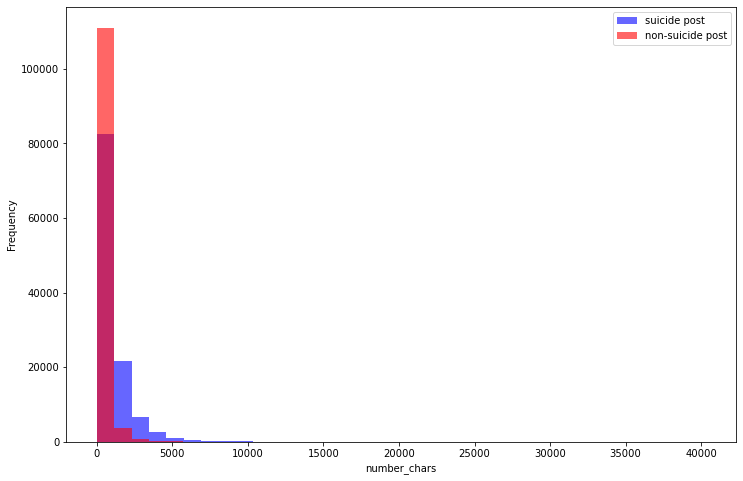

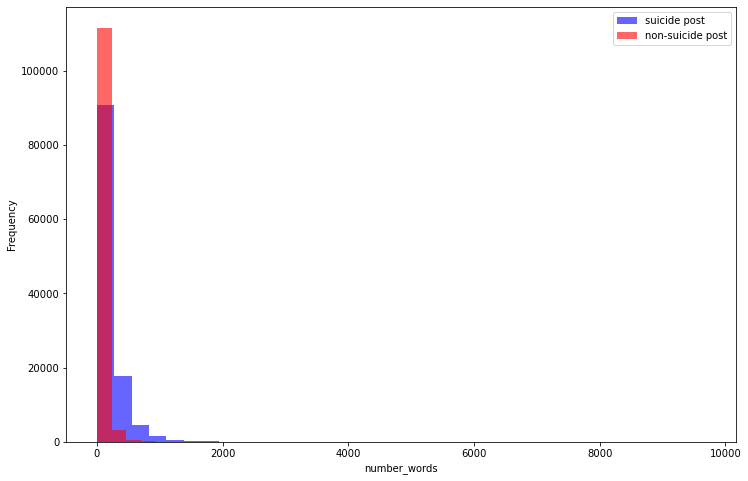

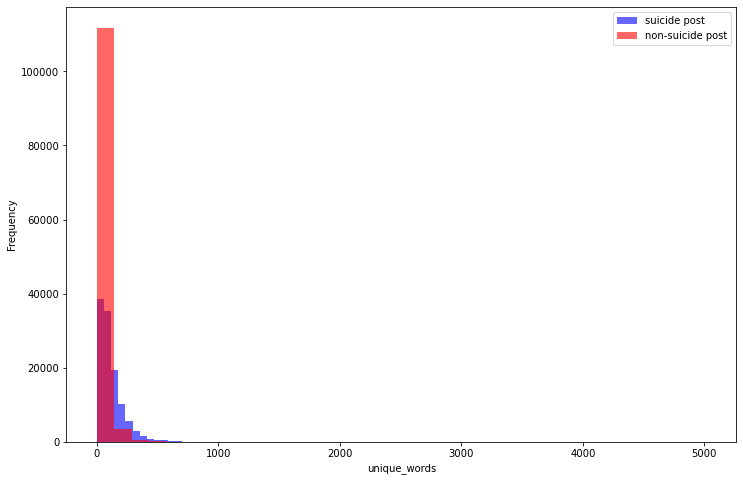

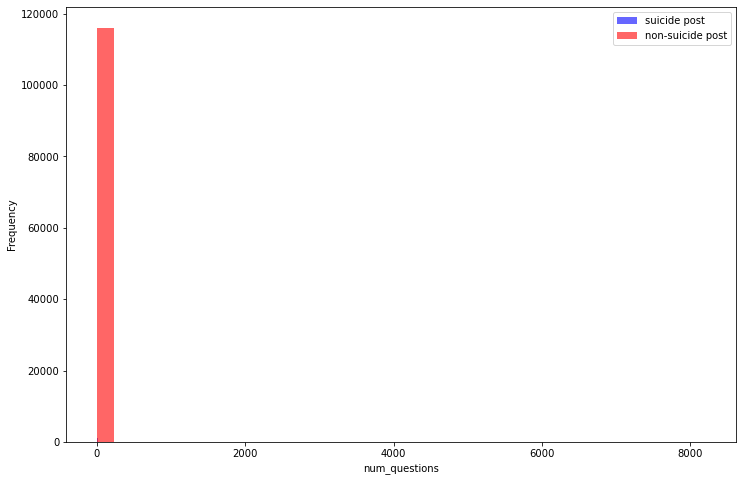

In [ ]:
for col in reddit_data.columns[2:]:
    plt.figure(figsize=(12, 8))
    reddit_data[reddit_data['class']=="suicide"][col].plot(bins=35, kind='hist', color='blue', label='suicide post', alpha=0.6)
    reddit_data[reddit_data['class']=="non-suicide"][col].plot(bins=35, kind='hist', color='red', label='non-suicide post', alpha=0.6)
    plt.xlabel(col)
    plt.legend()
    